In [15]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [18]:
np.random.seed(1337)
random.seed(1337)

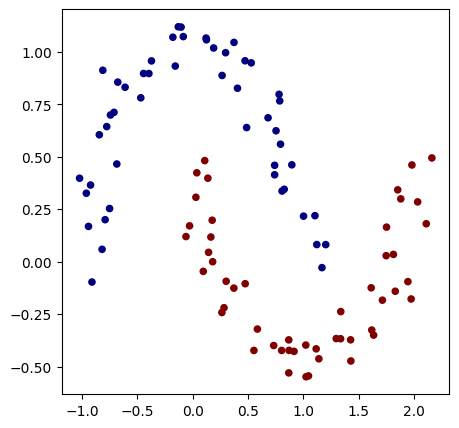

In [20]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [21]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print("number of parameters", len(model.parameters()))

number of parameters 337


In [22]:
# loss function
def loss(batch_size=None):
    
    # DataLoader
    if batch_size is None:
        Xb, yb = X, y
    else:
        # create a permutation of numbers from 0 to X size (X.shape[0]), and the take the first 'batch_size'
        ri = np.random.permutation(X.shape[0])[:batch_size]
        # extract the incidents in the positions in ri from X and y. 
        Xb, yb = X[ri], y[ri]

    # Convert numpy arrays to Value objects for backpropagation
    inputs = []
    for xrow in Xb:  # iterate through each training example
        value_row = []
        for x in xrow:  # iterate through each feature in the example
            value_row.append(Value(x))  # convert float to Value object
        inputs.append(value_row)
    
    # forward the model to get scores
    scores = []
    for input_example in inputs:
        score = model(input_example)  # run one example through the network
        scores.append(score)
    
    # svm "max-margin" loss
    losses = []
    for yi, scorei in zip(yb, scores):
        margin = 1 + (-yi * scorei)  # 1 - yi*scorei
        loss_i = margin.tanh()       # smooth approximation of hinge loss
        losses.append(loss_i)
    
    # Get the avg loss for the batch
    data_loss = sum(losses) * (1.0 / len(losses))

    # L2 regularization - give a panelty for large wights to avoid overfiiing.
    # as we calculate the regularization for each param, 
    # this will be added to the computational graph, and effect the gradient in the backprop and pull the wights down.
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)

Value(data=0.6183874424150523) 0.59


In [24]:
# optimization
for k in range(50):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    model.zero_grad()
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")

step 0 loss 0.156323015937886, accuracy 86.0%
step 1 loss 0.1602315819069709, accuracy 86.0%
step 2 loss 0.16486603437094788, accuracy 85.0%
step 3 loss 0.16189508036645975, accuracy 85.0%
step 4 loss 0.15599477642130402, accuracy 86.0%
step 5 loss 0.15427973997031905, accuracy 87.0%
step 6 loss 0.15392131543427814, accuracy 87.0%
step 7 loss 0.15227753367385188, accuracy 86.0%
step 8 loss 0.14271966269115352, accuracy 88.0%
step 9 loss 0.13887440862425876, accuracy 89.0%
step 10 loss 0.13632311811550582, accuracy 88.0%
step 11 loss 0.14222907060129916, accuracy 90.0%
step 12 loss 0.15284823101809245, accuracy 86.0%
step 13 loss 0.14412891497313726, accuracy 89.0%
step 14 loss 0.13359533295220474, accuracy 89.0%
step 15 loss 0.1343365408562962, accuracy 89.0%
step 16 loss 0.1342311963696407, accuracy 89.0%
step 17 loss 0.130143991713483, accuracy 89.0%
step 18 loss 0.12907845409052449, accuracy 89.0%
step 19 loss 0.12929862864096098, accuracy 89.0%
step 20 loss 0.12898187597821265, acc

(-1.548639298268643, 1.951360701731357)

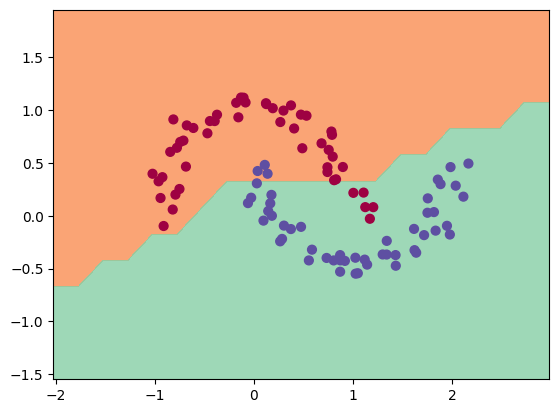

In [25]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())